In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flddata/resized_data/annotations/annotations_train.csv
/kaggle/input/flddata/resized_data/annotations/annotations_test.csv
/kaggle/input/flddata/resized_data/test/3052865023_4.jpg
/kaggle/input/flddata/resized_data/test/3233580660_1.jpg
/kaggle/input/flddata/resized_data/test/2982058191_1.jpg
/kaggle/input/flddata/resized_data/test/3042655945_1.jpg
/kaggle/input/flddata/resized_data/test/3052865023_3.jpg
/kaggle/input/flddata/resized_data/test/3213143311_1.jpg
/kaggle/input/flddata/resized_data/test/31681454_1.jpg
/kaggle/input/flddata/resized_data/test/3040240981_1.jpg
/kaggle/input/flddata/resized_data/test/3186478027_1.jpg
/kaggle/input/flddata/resized_data/test/3218988613_1.jpg
/kaggle/input/flddata/resized_data/test/3214097106_2.jpg
/kaggle/input/flddata/resized_data/test/305612849_1.jpg
/kaggle/input/flddata/resized_data/test/305917477_2.jpg
/kaggle/input/flddata/resized_data/test/3144473012_2.jpg
/kaggle/input/flddata/resized_data/test/3035796193_1.jpg
/kaggle/inpu

In [2]:
ROOT_PATH = "/kaggle/input/flddata"

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, utils
from tqdm import tqdm

In [4]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None) -> None:
        super().__init__()

        self.landmarks_frame = pd.read_csv(csv_file, index_col=0)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(image_name)
        landmarks = np.array(self.landmarks_frame.iloc[idx, 1:])
        landmarks = landmarks.astype("float").reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

class Rescale(object):
    def __init__(self, output_size):
        self.output_size = output_size


    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        h, w = image.shape[:2]

        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image,(new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]

        sample = {"image": image, "landmarks": landmarks}
        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}


class DropDictionary(object):
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        return image, landmarks
    
class Normalize(object):
    def __init__(self, mean, std):
        if not isinstance(mean, torch.Tensor):
            mean = torch.tensor(mean)

        if not isinstance(std, torch.Tensor):
            std = torch.tensor(std)

        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, annotation = sample

        # Subtract the mean and divide by the std
        mean = self.mean.reshape((3, 1, 1))
        std = self.std.reshape((3, 1, 1))
        image = (image - mean) / std

        return image, annotation

In [5]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [6]:
IN_FEATURES = model.fc.in_features
NUM_LANDMARKS = 194 * 2
model.fc = nn.Linear(in_features=IN_FEATURES, out_features=NUM_LANDMARKS)
print(model.fc)

Linear(in_features=512, out_features=388, bias=True)


In [7]:
# test save
print("Test saving model")
MODELS_DIR = "FLD_V3"
torch.save(model.state_dict(), MODELS_DIR)

Test saving model


In [8]:
from skimage.transform import rotate
import cv2

class RandomCrop(object):
    """Crop randomly the image in a sample."""

    def __init__(self, output_size):
        self.output_size = output_size 


    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class RandomRotation(object):

    def __init__(self, min_angle=-10, max_angle=10) -> None:
        self.min_angle = min_angle
        self.max_angle = max_angle
    
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        w, h = image.shape[:2]
        angle = np.random.uniform(self.min_angle, self.max_angle)
        rot_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        image = cv2.warpAffine(image, rot_matrix, (w, h))
        landmarks = cv2.transform(landmarks[:, np.newaxis, :], rot_matrix).squeeze()

        return {'image': image, 'landmarks': landmarks}


class RandomIntesityChange(object):
    def __init__(self, min_alpha=0.5, max_alpha=1.0):
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha

    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        alpha = np.random.uniform(self.min_alpha, self.max_alpha)
        beta = 0
        image = cv2.addWeighted(image, alpha, np.ones(image.shape, image.dtype), 0, beta)

        return {'image': image, 'landmarks': landmarks}

In [9]:
def show_landmarks(image, landmarks):
    if isinstance(image, torch.Tensor):
        image = image.numpy()
        image = image.transpose((1, 2, 0))

    if isinstance(landmarks, torch.Tensor):
        landmarks = landmarks.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.scatter(x=landmarks[:, 0], y=landmarks[:, 1], s=10, marker=".", c="green")
    plt.show()

(256, 256, 3) (194, 2)


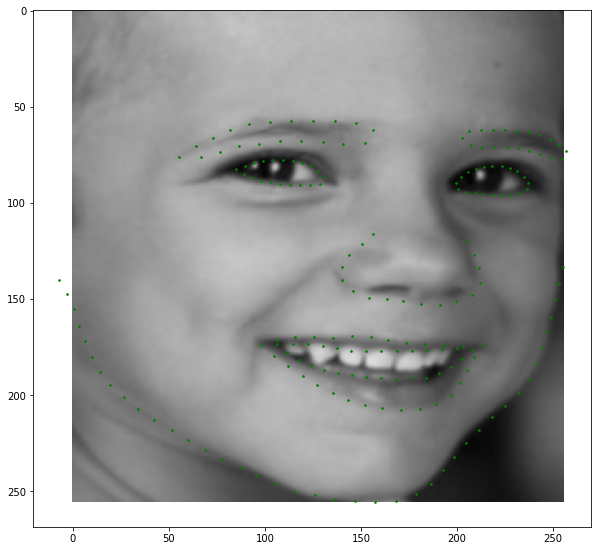

In [10]:
# Split training data into batches
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomCrop((245, 245)),
    Rescale((256, 256)),
    DropDictionary()
])

random_crop_data_set = FaceLandmarksDataset(csv_file=ROOT_PATH + "/resized_data/annotations/annotations_train.csv",
                                            root_dir=ROOT_PATH + "/resized_data/train/",
                                            transform=composed_transform)

x, y = random_crop_data_set[0]
print(x.shape, y.shape)
show_landmarks(x, y)

(256, 256, 3) (194, 2)


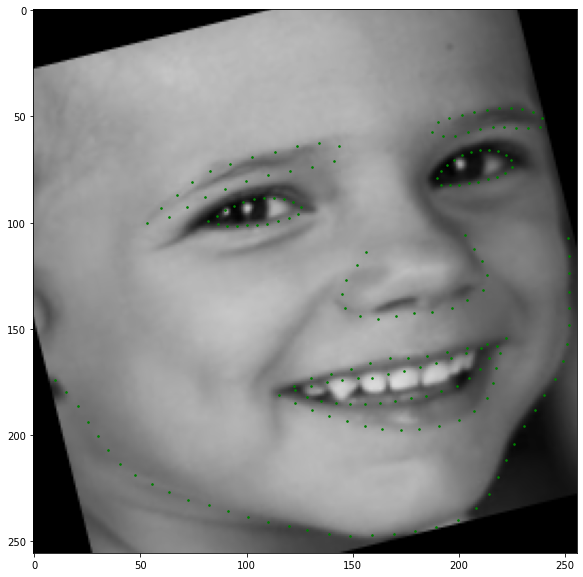

In [11]:
# Split training data into batches
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomRotation(-20, 20),
    DropDictionary()
])

random_angle_data_set = FaceLandmarksDataset(csv_file=ROOT_PATH + "/resized_data/annotations/annotations_train.csv",
                                            root_dir=ROOT_PATH + "/resized_data/train/",
                                            transform=composed_transform)

x, y = random_angle_data_set[0]
print(x.shape, y.shape)
show_landmarks(x, y)

(256, 256, 3) (194, 2)


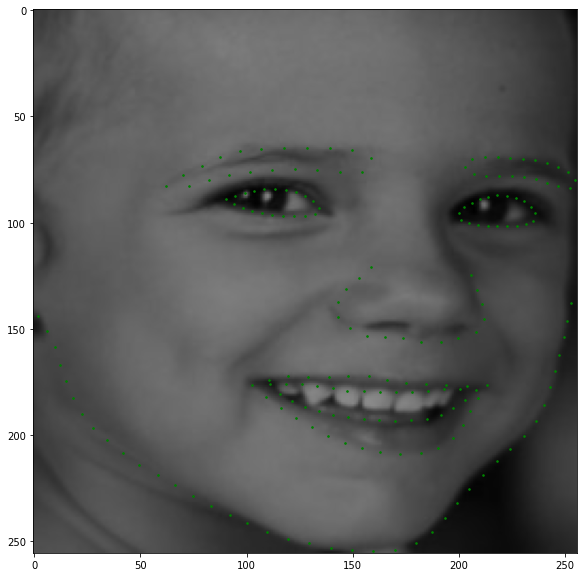

In [12]:
# Split training data into batches
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomIntesityChange(0.5, 1.50),
    DropDictionary()
])

random_intestiy_data_set = FaceLandmarksDataset(csv_file=ROOT_PATH + "/resized_data/annotations/annotations_train.csv",
                                            root_dir=ROOT_PATH + "/resized_data/train/",
                                            transform=composed_transform)

x, y = random_intestiy_data_set[0]
print(x.shape, y.shape)
show_landmarks(x, y)

In [13]:
train_mean = [0.5452, 0.4160, 0.3605]
train_std = [0.2692, 0.2363, 0.2336]

In [14]:
# (1) Original Dataset
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=train_mean, std=train_std)
])

original_data_set = FaceLandmarksDataset(csv_file=ROOT_PATH + "/resized_data/annotations/annotations_train.csv",
                                root_dir=ROOT_PATH + "/resized_data/train/",
                                transform=composed_transform)


# (2) Random Crop
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomCrop((245, 245)),
    Rescale((256, 256)),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=train_mean, std=train_std)
])

random_crop_data_set = FaceLandmarksDataset(csv_file=ROOT_PATH + "/resized_data/annotations/annotations_train.csv",
                                            root_dir=ROOT_PATH + "/resized_data/train/",
                                            transform=composed_transform)

# (3) Random Rotation
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomRotation(-20, 20),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=train_mean, std=train_std)
])

random_angle_data_set = FaceLandmarksDataset(csv_file=ROOT_PATH + "/resized_data/annotations/annotations_train.csv",
                                            root_dir=ROOT_PATH + "/resized_data/train/",
                                            transform=composed_transform)

# (4) Random Intestiy Change
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomIntesityChange(0.5, 1.5),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=train_mean, std=train_std)
])

random_intestiy_data_set = FaceLandmarksDataset(csv_file=ROOT_PATH + "/resized_data/annotations/annotations_train.csv",
                                            root_dir=ROOT_PATH + "/resized_data/train/",
                                            transform=composed_transform)

In [15]:
from torch.utils.data import ConcatDataset

augmented_data_set = ConcatDataset([original_data_set, random_crop_data_set, random_angle_data_set, random_intestiy_data_set])
print(f"num samples: {len(augmented_data_set)}")

num samples: 8000


In [16]:
BATCH_SIZE = 64

num_train = int(0.8 * len(augmented_data_set))
train_loader = DataLoader(Subset(augmented_data_set, range(num_train)),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

val_loader = DataLoader(Subset(augmented_data_set, range(num_train, len(augmented_data_set))),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

x_train_batch, y_train_batch = next(iter(train_loader))
x_val_batch, y_val_batch = next(iter(val_loader))

x_train_batch.shape, y_train_batch.shape, x_val_batch.shape, y_val_batch.shape

(torch.Size([64, 3, 256, 256]),
 torch.Size([64, 194, 2]),
 torch.Size([64, 3, 256, 256]),
 torch.Size([64, 194, 2]))

In [17]:
import time
start_time = time.time()

for batch_idx, sample_batched in enumerate(train_loader):
    image, landmarks = sample_batched
    print(batch_idx, image.size(), landmarks.size())
    
    break

print("--- %s seconds ---" % (time.time() - start_time))

0 torch.Size([64, 3, 256, 256]) torch.Size([64, 194, 2])
--- 1.8270018100738525 seconds ---


In [18]:
BEST_LR = 0.011342
BEST_WD = 0.000019

In [19]:
NUM_EPOCHS = 100
PRINT_PERIOD = 1
MODELS_DIR = "FLD_V3"

best_val_loss = None

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)
losses_train, losses_val= [], []

for epoch in range(NUM_EPOCHS):
    model = model.double()

    # Iterate over training batches
    start_time = time.time()

    for batch_idx, train_batch in enumerate(train_loader):
        x_train_batch, y_train_batch = train_batch

        # Move tensors and model on cuda if available
        if torch.cuda.is_available():
            device = torch.device("cuda")
            model = model.to(device)
            x_train_batch = x_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)

        # Forward pass
        y_train_hat = model(x_train_batch)
        y_train_hat = y_train_hat.reshape((y_train_batch.shape[0], -1, 2))

        # Compute loss
        loss = torch.nn.functional.mse_loss(y_train_hat, y_train_batch)
    
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_time = time.time() - start_time

    start_time = time.time()
    
    with torch.no_grad():
        # Evaluate on the whole training dataset
        train_loss = 0
        for n, (x_train_batch, y_train_batch) in enumerate(train_loader):
            if torch.cuda.is_available():
                device = torch.device("cuda")
                model = model.to(device)
                x_train_batch = x_train_batch.to(device)
                y_train_batch = y_train_batch.to(device)

            y_train_hat = model(x_train_batch)
            y_train_hat = y_train_hat.reshape((y_train_batch.shape[0], -1, 2))
            train_loss += torch.nn.functional.mse_loss(y_train_hat, y_train_batch).item()

        train_loss = train_loss / (n + 1) 

        # Evaluate on the whole validation dataset
        val_loss = 0
        for n, (x_val_batch, y_val_batch) in enumerate(val_loader):
            if torch.cuda.is_available():
                device = torch.device("cuda")
                model = model.to(device)
                x_val_batch = x_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)

            y_val_hat = model(x_val_batch)
            y_val_hat = y_val_hat.reshape((y_val_batch.shape[0], -1, 2)) 
            val_loss += torch.nn.functional.mse_loss(y_val_hat, y_val_batch).item()

        val_loss = val_loss / (n + 1)

        losses_train.append(train_loss)
        losses_val.append(val_loss)
        
    eval_time = time.time() - start_time

    if epoch % PRINT_PERIOD == 0:
        print(f"epoch: {epoch} \t train_time: {train_time} \t eval_time: {eval_time:.4f} \t train_loss: {loss:.4f} \t val_loss: {val_loss:.4f}")

    
    # Check if current model is the best so far and save it
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODELS_DIR)

epoch: 0 	 train_time: 183.66612672805786 	 eval_time: 253.1433 	 train_loss: 381.3312 	 val_loss: 293.9055
epoch: 1 	 train_time: 164.61250233650208 	 eval_time: 252.7928 	 train_loss: 166.0255 	 val_loss: 150.8969
epoch: 2 	 train_time: 166.8733479976654 	 eval_time: 252.9713 	 train_loss: 72.1566 	 val_loss: 84.6035
epoch: 3 	 train_time: 167.4909052848816 	 eval_time: 253.7070 	 train_loss: 78.2225 	 val_loss: 59.7021
epoch: 4 	 train_time: 165.3614592552185 	 eval_time: 252.6455 	 train_loss: 67.9149 	 val_loss: 52.2033
epoch: 5 	 train_time: 164.74281573295593 	 eval_time: 253.8754 	 train_loss: 46.0039 	 val_loss: 44.6239
epoch: 6 	 train_time: 165.5314929485321 	 eval_time: 252.5032 	 train_loss: 47.6990 	 val_loss: 39.6273
epoch: 7 	 train_time: 165.4014105796814 	 eval_time: 251.5218 	 train_loss: 38.6979 	 val_loss: 36.7373
epoch: 8 	 train_time: 164.94828867912292 	 eval_time: 252.7162 	 train_loss: 37.6965 	 val_loss: 33.7332
epoch: 9 	 train_time: 165.5099742412567 	 eval

In [20]:
torch.save(model.state_dict(), MODELS_DIR)

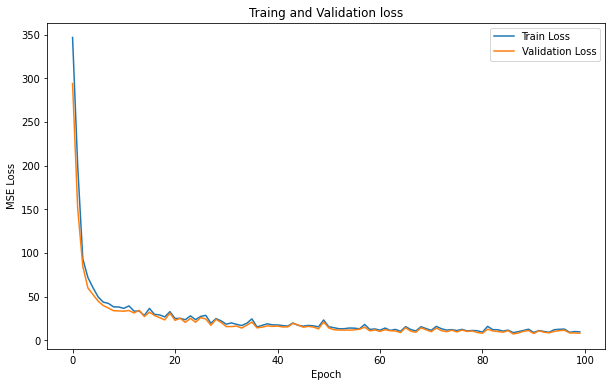

In [21]:
plt.figure(figsize=(10,6))
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_val, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Traing and Validation loss")
plt.legend()
plt.savefig("loss.png")

In [22]:
def plot_prediction(x, y, y_hat, n_samples=3, clip=False):
    # Move tensors to cpu and detach grad.
    x = x.to("cpu")
    y = y.to("cpu")
    y_hat = y_hat.to("cpu")
    x = x.detach()
    y = y.detach()
    y_hat = y_hat.detach()

    # Iterate over samples in the batch
    i = 0
    for x_i, y_i, y_hat_i in zip(x[:n_samples], y[:n_samples], y_hat[:n_samples]):
        if isinstance(x_i, torch.Tensor):
            x_i = x_i.numpy()
            x_i = x_i.transpose((1, 2, 0))
        
        if isinstance(y_i, torch.Tensor):
            y_i = y_i.numpy()

        fig, ax = plt.subplots(figsize=(10, 10));

        plt.figure(figsize=(10, 10));

        # Plot ground truth landmarks
        ax.scatter(x=y_i[:, 0], y=y_i[:, 1], s=20, marker=".");

        # Plot predicted landmarks
        ax.scatter(x=y_hat_i[:, 0], y=y_hat_i[:, 1], s=20, marker=".");

        if clip: 
            ax.imshow(np.clip(x_i, 0, 1))
        else:
            ax.imshow(x_i);
            
        i += 1
            
        print(f"saving prediction_{i}")
        fig.savefig(f"prediction_{i}");

saving prediction_1
saving prediction_2
saving prediction_3


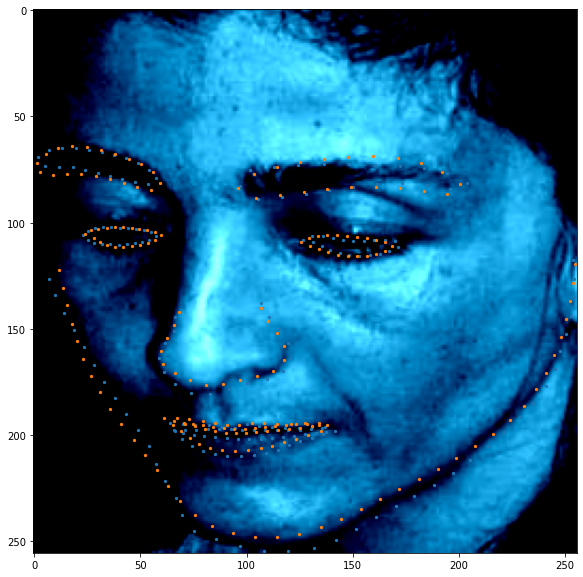

<Figure size 720x720 with 0 Axes>

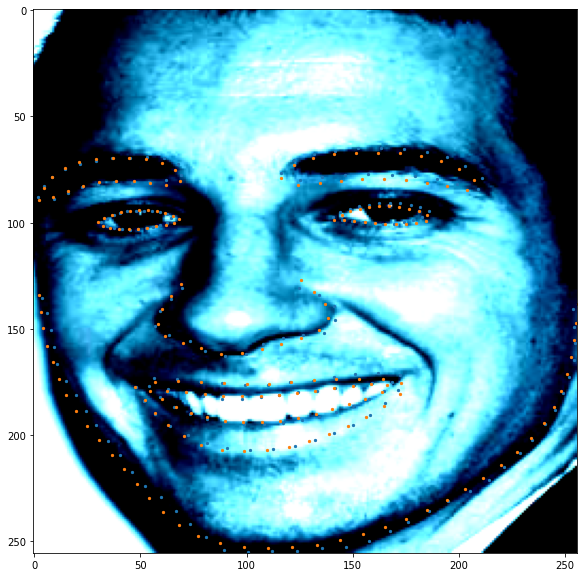

<Figure size 720x720 with 0 Axes>

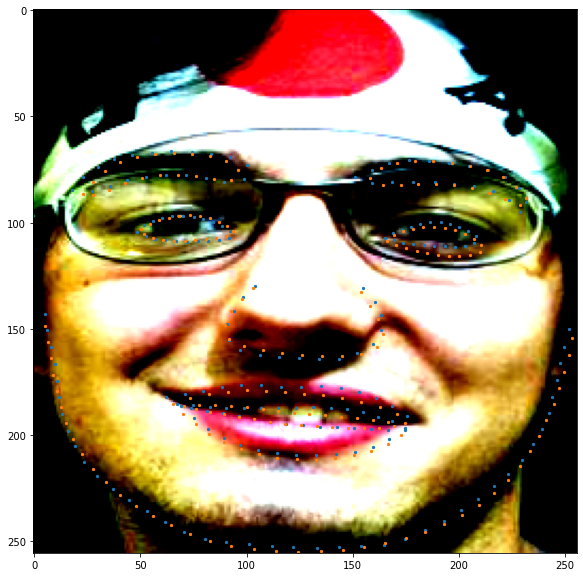

<Figure size 720x720 with 0 Axes>

In [23]:
plot_prediction(x_val_batch, y_val_batch, y_val_hat, n_samples=3, clip=True)